In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
df['Speed Difference (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Wind Speed (TAO)']

df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (QuikSCAT)'] = (-(df['Wind Direction (QuikSCAT)'] - 90.0) + 360)%360
df['mean WDIR 30min'] = (-(df['mean WDIR 30min'] - 90.0) + 360)%360
df['mean WDIR 60min'] = (-(df['mean WDIR 60min'] - 90.0) + 360)%360
df['mean WDIR 120min'] = (-(df['mean WDIR 120min'] - 90.0) + 360)%360

df['Direction Difference (QuikSCAT - TAO)'] = ((df['Wind Direction (QuikSCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 30 min mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 30min']
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 30min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 30 min mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 1 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 60min']
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 60min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 1 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 2 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 120min']
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 120min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 2 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = dirDiff


df['Zonal Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

df['Zonal Wind Speed Difference (QuikSCAT - TAO)'] = df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] - df['Zonal Neutral Wind Speed at 10m (TAO)']
df['Meridional Wind Speed Difference (QuikSCAT - TAO)'] = df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] - df['Meridional Neutral Wind Speed at 10m (TAO)']

df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['tan(2 Direction Difference (QuikSCAT - TAO))'] = np.tan(2 * np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))

In [4]:
df

,Wind Direction (TAO),WDIR_QC,WDIR_DM,Wind Speed (TAO),WSPD_QC,WSPD_DM,Zonal Wind Speed (TAO),Meridional Wind Speed (TAO),Sea Surface Temperature (TAO),SST_QC,...,Direction Difference (QuikSCAT - TAO 2 hr mean),Zonal Neutral Wind Speed at 10m (TAO),Meridional Neutral Wind Speed at 10m (TAO),Zonal Neutral Wind Speed at 10m (QuikSCAT),Meridional Neutral Wind Speed at 10m (QuikSCAT),Zonal Wind Speed Difference (QuikSCAT - TAO),Meridional Wind Speed Difference (QuikSCAT - TAO),cos(Direction Difference (QuikSCAT - TAO)),sin(Direction Difference (QuikSCAT - TAO)),tan(2 Direction Difference (QuikSCAT - TAO))
count,,,,,,,,,,,,,,,,,,,,,
0,123.599976,2.0,b'D',5.39,2.0,b'D',-2.98,4.49,23.745001,2.0,...,-3.048798,-3.279486,4.936027,-3.242902,4.744808,0.036584,-0.191218,0.999914,0.013110,0.026227
1,128.200012,2.0,b'D',5.30,2.0,b'D',-3.28,4.17,23.743000,2.0,...,-1.897095,-3.609605,4.586987,-3.291839,4.614499,0.317766,0.027512,0.998892,-0.047057,-0.094427
2,128.700012,2.0,b'D',5.04,2.0,b'D',-3.15,3.93,23.938000,2.0,...,-3.936981,-3.464800,4.324776,-3.617737,4.927110,-0.152936,0.602334,0.999114,-0.042085,-0.084394
3,129.400024,2.0,b'D',5.46,2.0,b'D',-3.46,4.22,23.927999,2.0,...,-3.390045,-3.803853,4.630883,-3.680622,4.913736,0.123230,0.282853,0.998998,-0.044754,-0.089778
4,132.200012,2.0,b'D',5.52,2.0,b'D',-3.70,4.09,23.716999,2.0,...,0.426117,-4.067513,4.485841,-4.013830,4.503524,0.053683,0.017683,0.999963,-0.008561,-0.017125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244382,217.299988,2.0,b'D',6.46,2.0,b'D',-5.14,-3.91,26.746000,2.0,...,-7.947189,-5.652826,-4.306297,-8.567538,-2.949113,-2.914711,1.357183,0.949395,-0.314084,-0.742965
244383,216.000000,2.0,b'D',5.79,2.0,b'D',-4.68,-3.40,26.754999,2.0,...,-9.230347,-5.154537,-3.744989,-8.062730,-2.656954,-2.908193,1.088035,0.952337,-0.305049,-0.713879
244384,218.500000,2.0,b'D',9.70,2.0,b'D',-7.59,-6.04,26.757000,2.0,...,-5.149033,-8.325221,-6.622177,-9.786770,-5.732526,-1.461549,0.889651,0.989923,-0.141604,-0.292068


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Direction (TAO)', ylabel='Wind Direction (QuikSCAT)'>

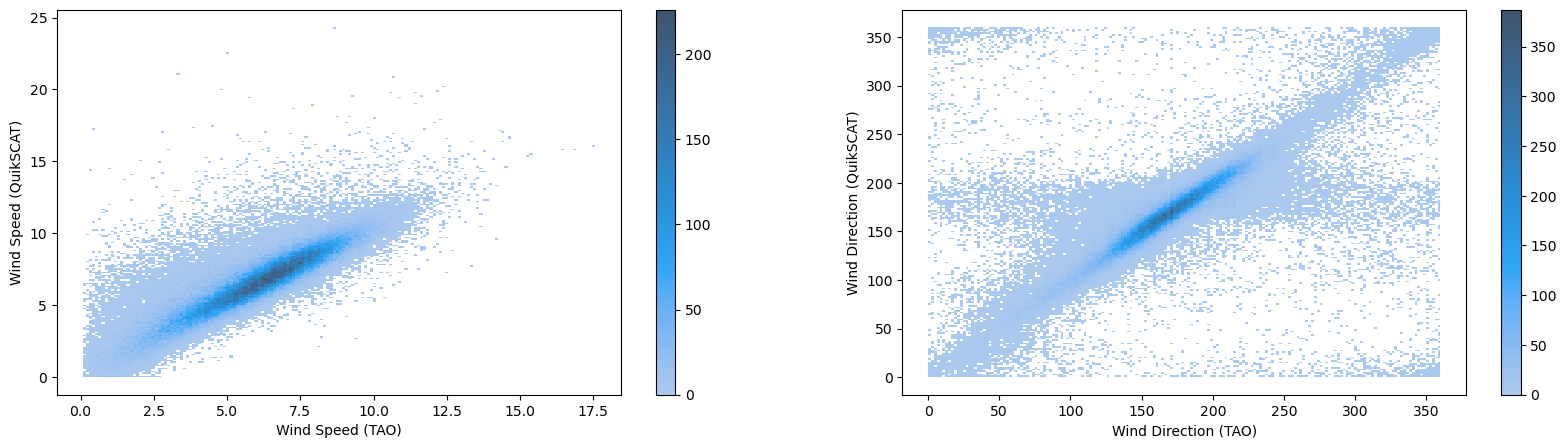

In [5]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,5))
ax = axes[0]
sns.histplot(df, x='Wind Speed (TAO)', y='Wind Speed (QuikSCAT)', cbar=True, ax= ax)
#sns.regplot(ds, x='WSPD_10N', y='retrieved_wind_speed', scatter= False, robust=True, ax = ax)
ax = axes[1]
sns.histplot(df, x='Wind Direction (TAO)', y='Wind Direction (QuikSCAT)', cbar=True, ax= ax)
#sns.regplot(ds, x='WDIR', y='retrieved_wind_direction', scatter=False, robust=True, ax= ax)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

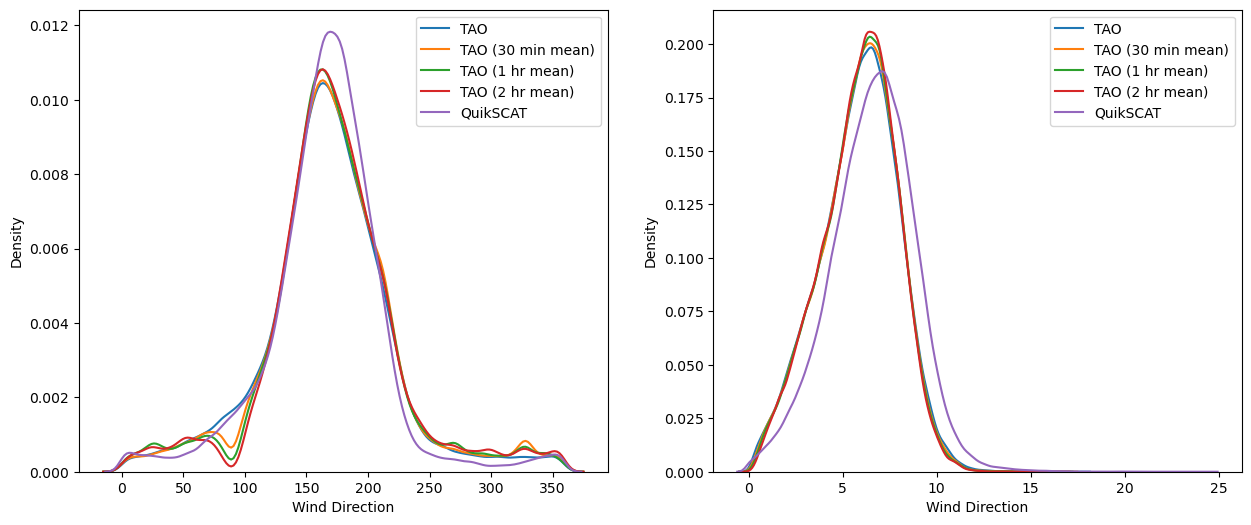

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Speed (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

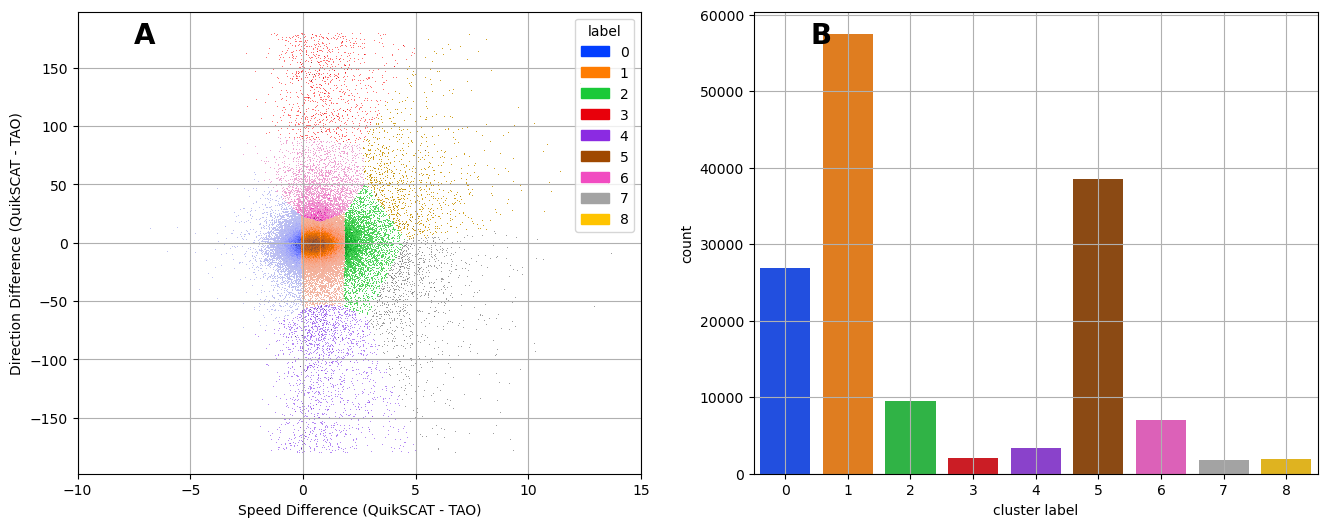

In [8]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
           'Direction Difference (QuikSCAT - TAO)']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


# plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='Speed Difference (QuikSCAT - TAO)', ylabel='Direction Difference (QuikSCAT - TAO)'>

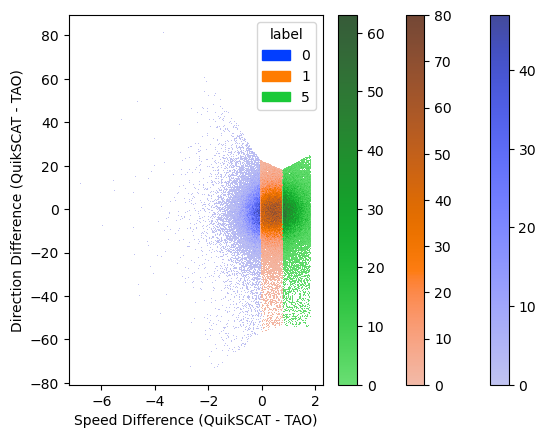

In [22]:
subDF = df.loc[df['label'].isin([0,1,5])]
sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=False, cbar= True, 
                palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

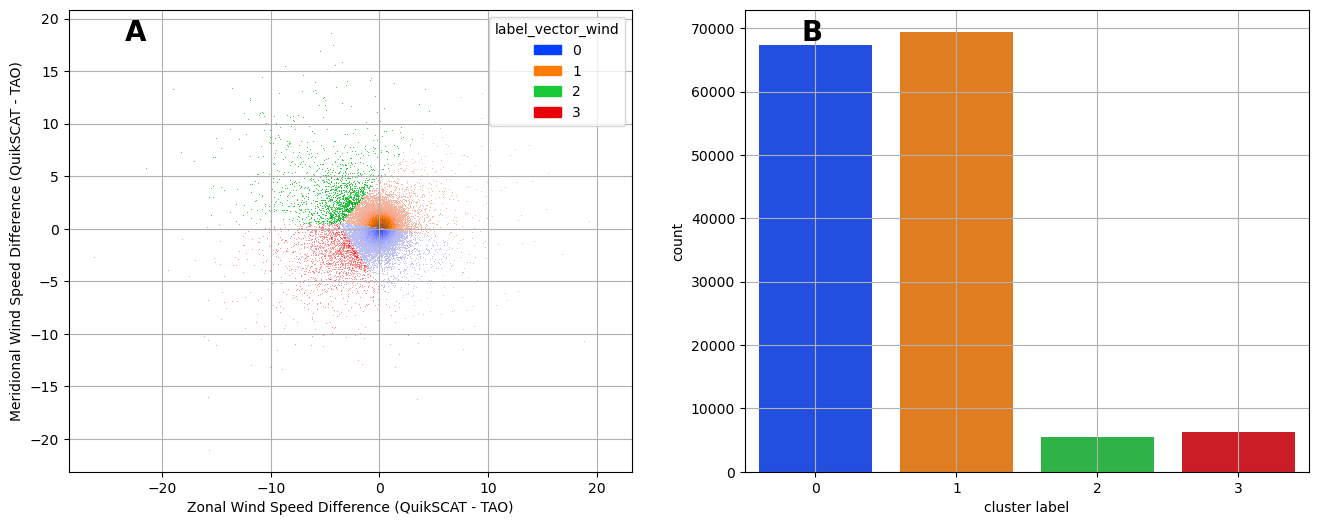

In [8]:
selectX = ['Zonal Wind Speed Difference (QuikSCAT - TAO)',
           'Meridional Wind Speed Difference (QuikSCAT - TAO)']

X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label_vector_wind'] = kmeans.labels_

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'Zonal Wind Speed Difference (QuikSCAT - TAO)'
ylabel = 'Meridional Wind Speed Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel, #levels=10, 
                hue='label_vector_wind', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

#ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label_vector_wind',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


plt.savefig('PDF_byCluster_10min_VectorWind.png', dpi=100)

In [ ]:
var = 'Speed Difference (QuikSCAT - TAO)'
labelVal = 0

def getPDFplotFor(ax, df, labelVal, var, labelName ='label'):
    sns.histplot(df.loc[df[labelName] == labelVal], x = var, ax = ax, bins = 50)
    ax.axvline(x = medians[labelVal], ymin= 0 , ymax = 0.25, color = 'r',  label = 'median')
    ax.axvline(x = means[labelVal], ymin= 0 , ymax = 0.25, color = 'blue',linestyle = '--', label = 'mean')
    ax.axvline(x = means[labelVal]-stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange', label = 'std. Dev')
    ax.axvline(x = means[labelVal]+stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange')
    
    text = f' mean: {means[labelVal]:6.2f} \n median: {medians[labelVal]:6.2f} \n stdDev: {stdDevs[labelVal]:6.2f}'
    
    
    ax.text(0.05, 0.95, text, horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha= 0.5))
    ax.legend(loc='upper right')

In [ ]:
var = 'Speed Difference (QuikSCAT - TAO)'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))

for labelVal in range(9):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))
    

In [ ]:
var = 'Direction Difference (QuikSCAT - TAO)'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))

for labelVal in range(9):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))


In [ ]:
var = 'Speed Difference (QuikSCAT - TAO)'

medians = df.groupby(['label_vector_wind'])[var].median()
means = df.groupby(['label_vector_wind'])[var].mean()
stdDevs = df.groupby(['label_vector_wind'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for labelVal in range(4):
    ii = int(labelVal//2)
    jj = labelVal%2
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var, labelName = 'label_vector_wind')
    ax.set_title('Cluster: '+ str(labelVal))
    

In [ ]:
var = 'Direction Difference (QuikSCAT - TAO)'

medians = df.groupby(['label_vector_wind'])[var].median()
means = df.groupby(['label_vector_wind'])[var].mean()
stdDevs = df.groupby(['label_vector_wind'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for labelVal in range(4):
    ii = int(labelVal//2)
    jj = labelVal%2
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var, labelName = 'label_vector_wind')
    ax.set_title('Cluster: '+ str(labelVal))

In [ ]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([2,3,4,5,6,7])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

In [ ]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        

        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF['Neutral Wind Speed at 10m (TAO)'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def getXSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        QSdir = (-subDF['Wind Direction (QuikSCAT)'].to_numpy()-90)%360
        TAOspeed = subDF['Neutral Wind Speed at 10m (TAO)'].to_numpy()
        TAOdir = (-subDF['Wind Direction (TAO)'].to_numpy()-90)%360
        QSspeed_x = QSspeed * np.cos(np.deg2rad(QSdir))
        TAOspeed_x = TAOspeed * np.cos(np.deg2rad(TAOdir))
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        QSdir = (-subDF['Wind Direction (QuikSCAT)'].to_numpy()-90)%360
        TAOspeed = subDF['Neutral Wind Speed at 10m (TAO)'].to_numpy()
        TAOdir = (-subDF['Wind Direction (TAO)'].to_numpy()-90)%360
        QSspeed_y = QSspeed * np.sin(np.deg2rad(QSdir))
        TAOspeed_y = TAOspeed * np.sin(np.deg2rad(TAOdir))      
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


def getDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF['Wind Direction (TAO)'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999
    

In [ ]:
getGoodBad(0, -140, df), getBadPercent(0, -140, df), 

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=0.95, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
dateTime =df['QS_TIME']
dateTime[0].year

In [ ]:
# cdfDates = num2date(df['time'], 'seconds since 1990-01-01 00:00:00')
# dateTime = np.array([datetime(cdf.year, cdf.month, cdf.day, cdf.hour, cdf.minute) for cdf in cdfDates])
day_of_year = np.array([date.timetuple().tm_yday for date in dateTime])
df['dateTime'] = dateTime
df['day'] = day_of_year

In [ ]:
def getWindSpeedStd(lat, lon, df, timeWindow='30min'):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        mean_wspdStd2hr	 = np.mean(subDF['std. dev. WSPD '+timeWindow])
        return mean_wspdStd2hr
    else:
        return -999


def getWindDirStd(lat, lon, df, timeWindow='30min'):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        mean_wspdStd2hr	 = np.mean(subDF['std. dev. WDIR '+timeWindow])
        return mean_wspdStd2hr
    else:
        return -999
    

In [ ]:
df.head()

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'] == 0]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=1000, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 0')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'] == 1]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=1500, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 1')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'] == 8]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=1500, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 8')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'].isin([2,3,4,5,6,7])]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=700, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 2,3,4, 5, 6 and 7')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 2, 
                       ncols = 1, 
                        figsize = (20,10),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getWindSpeedStd(lat, lon, df)
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0.20, vmax=0.4, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax= ax)
cb.ax.set_title('wind speed \n std.dev. [m/s]')

ax = axes[1]
ax.add_feature(land)
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wdirStd = getWindDirStd(lat, lon, df)
    if wdirStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wdirStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wdirStd, vmin=2, vmax=15, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('wind dir \n std.dev. [degrees]')


#plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 2, 
                       ncols = 1, 
                        figsize = (20,10),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getWindSpeedStd(lat, lon, df, timeWindow='60min')
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0.20, vmax=0.5, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax= ax)
cb.ax.set_title('wind speed \n std.dev. [m/s]')

ax = axes[1]
ax.add_feature(land)
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wdirStd = getWindDirStd(lat, lon, df, timeWindow='60min')
    if wdirStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wdirStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wdirStd, vmin=2, vmax=15, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('wind dir \n std.dev. [degrees]')


#plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 2, 
                       ncols = 1, 
                        figsize = (20,10),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getWindSpeedStd(lat, lon, df, timeWindow='120min')
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0.20, vmax=0.6, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax= ax)
cb.ax.set_title('wind speed \n std.dev. [m/s]')

ax = axes[1]
ax.add_feature(land)
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wdirStd = getWindDirStd(lat, lon, df, timeWindow='120min')
    if wdirStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wdirStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wdirStd, vmin=2, vmax=15, s=60,  cmap='turbo')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('wind dir \n std.dev. [degrees]')


#plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wdirStd = getWindDirStd(lat, lon, df)
    if wdirStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wdirStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wdirStd, vmin=5, vmax=25, s=80,  cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('wind direction \n std.dev. [deg]')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)
    

In [ ]:
def get30minMeanSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF['wspdMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def get30minMeanDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['LATITUDE'] == LAT]
        subDF = subDF.loc[subDF['LONGITUDE'] == LON]
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF['wdirMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=60, cmap='coolwarm')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=0.92, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.4, vmax=0.86, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=1, s=40, cmap=cm.turbo)
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=1, s=40, cmap=cm.turbo)
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Wind Direction Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=1, s=40, cmap=cm.turbo)
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=1, s=40, cmap=cm.turbo)
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad_byMatchupLabel.png', dpi=100)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = int(365//3)
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
################################################################################################

In [ ]:
subDF

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    #ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'Zonal Neutral Wind Speed at 10m (TAO)', 'Direction Difference (QuikSCAT - TAO)')

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(15,12))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_SST,
             hue='Matchup Agreement', 
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[0,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_U10x,
             hue='Matchup Agreement',
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             bins= custom_bins_RH, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel,
             bins= custom_bins_SST, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[1,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_U10x, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             bins = custom_bins_RH,  
             hue='Matchup Agreement', 
             multiple=histkind,  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_SST, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[2,3]

sns.histplot(subDF.iloc[::-1], x=xlabel,
             bins= custom_bins_U10x, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)

In [ ]:
xlabel = 'rain_impact'
title = 'For Buoy locations lat > 3 N'
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False)#, 
             #ax = ax)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =5, sharex = False, figsize=(15,12))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

xlabel = 'rain_impact'
ax = axes[0,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

xlabel = 'rain_impact'
ax = axes[1,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

xlabel = 'rain_impact'
ax = axes[2,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement',
             #kind='kde',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,#)
             common_norm=False, 
             ax = ax)
            
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(65,100,50)
ny = 10

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################


title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################


ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
#plt.savefig('QuikSCAT_RH.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'Sea Surface Temperature (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
#plt.savefig('QuikSCAT_SST.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = False, figsize=(10,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'Sea Surface Temperature (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel(r'$\degree C$')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(r'$\degree C$')
################################################################################################


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
              ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order,
             ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'Direction Difference (QuikSCAT - TAO)')
ax.set_ylabel('direction Diff.')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'Speed Difference (QuikSCAT - TAO)')
ax.set_xlabel('Zonal Wind [m/s]')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
#plt.savefig('QuikSCAT_zonalWinds.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = True, figsize=(10,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'Zonal Neutral Wind Speed at 10m (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             #palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,10,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             #palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,15,50)
ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             #palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')
################################################################################################


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'Zonal Neutral Wind Speed at 10m (TAO)', 'Direction Difference (QuikSCAT - TAO)')

In [ ]:
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [ ]:
# xlabel = 'Speed Difference (QuikSCAT - TAO)'
# ylabel = 'Direction Difference (QuikSCAT - TAO)'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [ ]:
pdfPlotTest('Speed Difference (QuikSCAT - TAO)', 'Direction Difference (QuikSCAT - TAO)', df, nx = 50, ny =50)

In [ ]:
sns.kdeplot(subDF, x='Speed Difference (QuikSCAT - TAO)', y='Direction Difference (QuikSCAT - TAO)', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [ ]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.histplot(df, x='Speed Difference (QuikSCAT - TAO)', y='Direction Difference (QuikSCAT - TAO)')#, hue='label')

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)

In [ ]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,5))

ax = axes[0]
sns.histplot(df[df['label'].isin([0,1,8])], x='Neutral Wind Speed at 10m (TAO)', y='Wind Speed (QuikSCAT)', cbar=True, ax= ax)

ax = axes[1]
sns.histplot(df[df['label'].isin([0,1,8])], x='Wind Direction (TAO)', y='Wind Direction (QuikSCAT)', cbar=True, ax= ax)


In [ ]:
subset = allDS.isel(count = np.arange(100))

In [ ]:
plt.figure()
for count in subset['count']:
    subset['QS-Buoy'].isel(count = count) 

In [ ]:
diff = subset['retrieved_wind_direction'] - subset['WDIR']
diff2 = subset['retrieved_wind_speed'] - subset['WSPD']

In [ ]:
for i in range(10,20):
    diff.isel(count=i).plot(ylim = (-20,20))
    

In [ ]:
for i in range(10,20):
    diff2.isel(count=i).plot(ylim = (-2,2))